In [332]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [333]:
#### Preprocecing ###

In [334]:
Confirmed = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [335]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df

In [336]:
contries = confirmed.max() >= 1000
confirmed = confirmed.loc[:, contries]

In [337]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.loc[:, contries]


In [338]:
df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.loc[:, contries]


In [339]:
removed = recovered + death

In [340]:
epoch = pd.to_datetime('2020-02-15')

In [341]:
### Data Preparation ###

In [343]:
country = 'Korea, South'
I0 = (confirmed - removed)[country][epoch:].values
R0 = recovered[country][epoch:].values
D = death[country][epoch:].values
N = 5000_0000
repeat=10
iter=1000

In [344]:
data = {'T': I0.shape[0], 'N': N, 'I0': I0, 'R0': R0, 'D': D}

In [345]:
### Model ###

In [358]:
sm = pystan.StanModel(file="turzin.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aaa905c7e658db993664a7d651c670ea NOW.


In [359]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=iter)

In [360]:
### Simulation and Visualization functions ###

In [370]:
def sigmoid(start, theta, x):
    return 1 / (1 + np.exp(theta * (x - start)))
    

In [443]:
def simulate(l0, beta0, beta1, b_date, theta, gamma, delta, q1, q2, 
             theta_q, q_date, sigma_R, sigma_I, sigma_I0, sigma_R0, sigma_D, horizon):
    susceptible = N
    infected = l0
    recovered = 0
    death = 0
    susceptible_list = []
    infected_list = []
    recovered_list = []
    death_list = []
    infected0_list = []
    recovered0_list = []
    b_list = []
    q_list = []
    
    for d in range(horizon):
        b = beta0 + (beta1 - beta0) * sigmoid(b_date, theta, d) # transmission rate
        q = q1 + (q2 - q1) * sigmoid(q_date, theta_q, d) # observation rate
        NI = b * infected * (susceptible / N) +  np.sqrt(sigma_I) * np.random.randn()
        R = gamma * infected + np.sqrt(sigma_R) * np.random.randn()
        D = delta * infected + np.sqrt(sigma_D) * np.random.randn()
        
        susceptible = max(susceptible - recovered, 0)
        infected = max(infected + NI - R - D, l0)
        recovered = recovered + R
        death = death + D
        
        susceptible_list.append(susceptible)
        infected_list.append(infected)
        recovered_list.append(recovered)
        death_list.append(death)
        b_list.append(b)
        q_list.append(q)
        
        infected0_list.append(q * infected + np.sqrt(sigma_I0) * np.random.randn())
        recovered0_list.append(q * recovered + np.sqrt(sigma_R0) * np.random.randn())
        
    result = pd.DataFrame({
        'Susceptible':susceptible_list, 
        'Infected':infected_list,
        'Death':death_list,
        'Recovered':recovered_list,
        'Observed Infection':infected0_list,
        'Observed Recovered':recovered0_list,
        'Growth Rate':b_list,
        'Detection Rate':q_list},              
        index=pd.date_range(epoch, periods=horizon, freq='D'))
        
    return result

In [451]:
def monte_carlo(fit, horizon):
    observed_infected = []
    observed_recovered = []
    death = []
    b = []
    q = []
    n = fit['l0'].shape[0]
    for i in range(n):
        l0 = fit['l0'][i]
        beta0 = fit['beta0'][i]
        beta1 = fit['beta1'][i]
        b_date = fit['b_date'][i]
        theta = fit['theta'][i]
        gamma = fit['gamma'][i]
        delta = fit['delta'][i]
        q1 = fit['q1'][i]
        q2 = fit['q2'][i]
        theta_q = fit['theta_q'][i]
        q_date = fit['q_date'][i]
        sigma_R = fit['sigma_R'][i]
        sigma_I = fit['sigma_I'][i]
        sigma_I0 = fit['sigma_I0'][i]
        sigma_R0 = fit['sigma_R0'][i]
        sigma_D = fit['sigma_D'][i]
        result = simulate(l0=l0, beta0=beta0, beta1=beta1, b_date=b_date, 
                          theta=theta, gamma=gamma, delta=delta, 
                          q1=q1, q2=q2, theta_q=theta_q, q_date=q_date, 
                          sigma_R=sigma_R, sigma_I=sigma_I, sigma_I0=sigma_I0, 
                          sigma_R0=sigma_R0, sigma_D=sigma_D, horizon=horizon)
        observed_infected.append(result['Observed Infection'])
        observed_recovered.append(result['Observed Recovered'])
        death.append(result['Death'])
        b.append(result['Growth Rate'])
        q.append(result['Detection Rate'])
    observed_infected = pd.concat(observed_infected, axis=1)
    observed_recovered = pd.concat(observed_recovered, axis=1)
    death = pd.concat(death, axis=1)
    b = pd.concat(b, axis=1)
    q = pd.concat(q, axis=1)
    return observed_infected, observed_recovered, death, b, q

In [465]:
def draw(simulated, real=None):
    graph=pd.DataFrame()
    simulated = simulated.dropna(axis=1)
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

In [466]:
observed_infected, observed_recovered, death, b, q = monte_carlo(fit, 120)

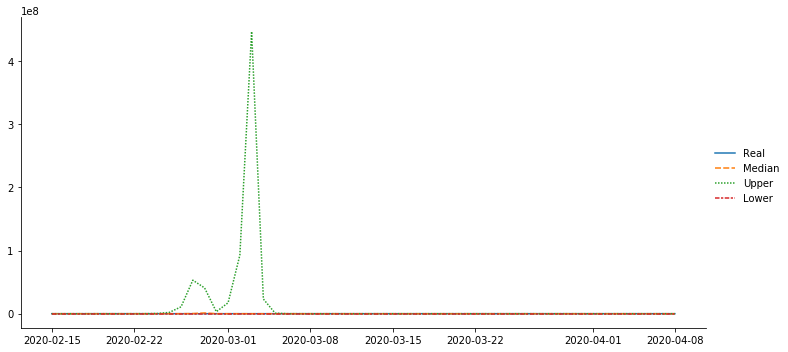

In [467]:
draw(observed_infected, real=(confirmed - removed)[country][epoch:])

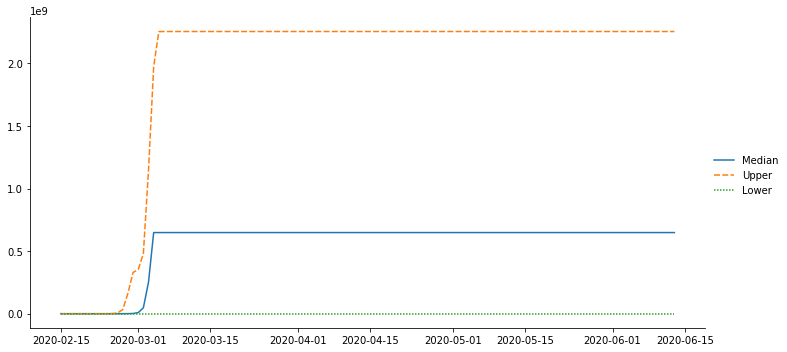

In [468]:
draw(death)

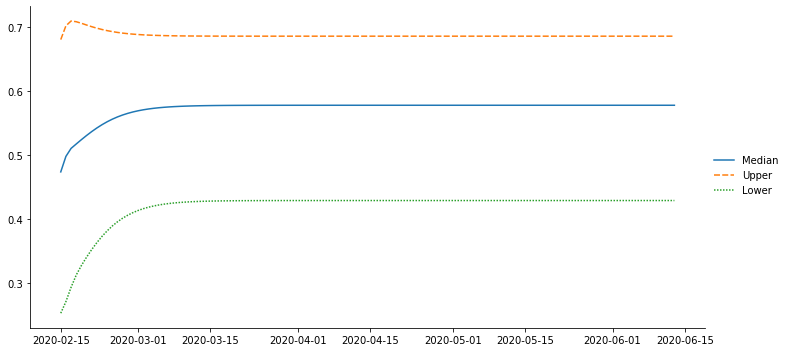

In [455]:
draw(q)

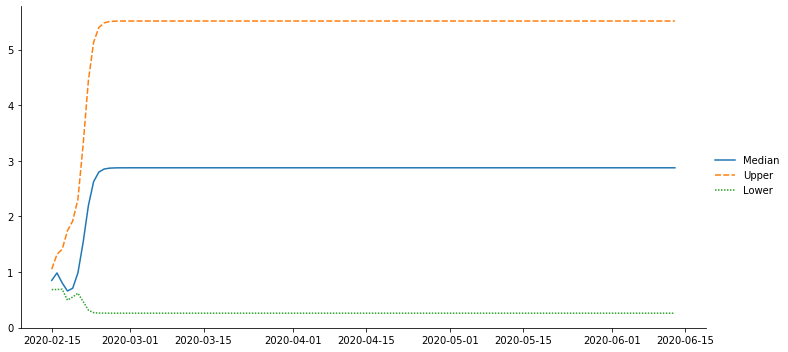

In [456]:
draw(b)

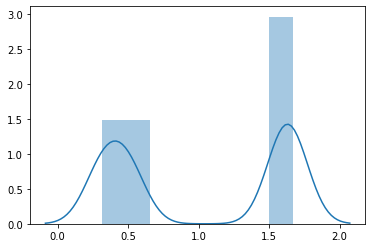

In [459]:
sns.distplot(fit['q_date'])

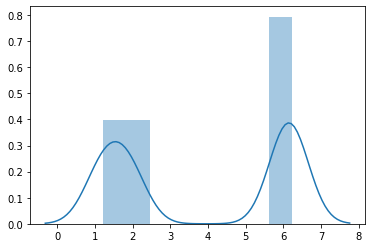

In [460]:
sns.distplot(fit['b_date'])